# Modeling - XGBoost

### Summary:
This notebook aims to establish the viability of the XGBoost algorithm for the purpose of modeling critical wine ratings using scraped weather data. Supporting these goals, performance metrics, residual plots, and feature importance’s are generated to support comparison across model families.

In [1]:
# general imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import dill
from scipy.stats import uniform, randint

# preprocessing packages
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer
from sklearn.impute import SimpleImputer

# pipeline tools
from sklearn.base import TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV, RepeatedKFold

# feature selection tools
from sklearn.feature_selection import VarianceThreshold

#models
from xgboost import XGBRegressor

#metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

In [2]:
# establish directory locations
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
processed_data_folder = parent_directory + '/data/wunderground-com/processed/'
models_folder = parent_directory + '/models/'
images_folder = parent_directory + '/images/'

### Load Data

In [3]:
df = pd.read_csv(processed_data_folder + '1678665697.3855994.txt', 
                 sep = '|')

In [4]:
df.head()

,Product_Name,Product_Varietal,Product_Origin,Product_Price,Product_Attributes,User_Avg_Rating,User_Rating_Count,Product_Vintage,Critical_Avg_Rating,Critical_Rating_Count,...,Jan_Min_Low_Wind_Speed,Jan_Max_High_Pressure,Jan_Avg_High_Pressure,Jan_Min_High_Pressure,Jan_Avg_Pressure,Jan_Max_Low_Pressure,Jan_Avg_Low_Pressure,Jan_Min_Low_Pressure,Jan_Average_Precipitation,Jan_Total_Precipitation
0,Domaine Taupenot-Merme Nuits-Saint-Georges Les...,Pinot Noir,"Nuits-St-Georges, Cote de Nuits, Cote d'Or, Bu...",199.99,Red Wine,0.0,0,2017,93.000000,3,...,0.0,29.8,29.493548,29.1,29.416129,29.8,29.354839,28.7,0.000000,0.00
1,Domaine de la Romanee-Conti Echezeaux Grand Cru,Pinot Noir,"Flagey-Echezeaux, Cote de Nuits, Cote d'Or, Bu...","3,299.99",Red Wine,0.0,0,2018,95.000000,4,...,0.0,29.9,29.384211,28.9,29.252632,29.8,29.157895,28.8,0.000000,0.00
2,Lincourt Rancho Santa Rosa Pinot Noir,Pinot Noir,"Sta. Rita Hills, Santa Barbara, Central Coast,...",40.99,Red Wine,4.0,31,2018,90.666667,3,...,0.0,30.3,30.135484,29.9,30.064516,30.2,30.000000,29.5,0.087742,2.72
3,Domaine Claude Dugat Gevrey-Chambertin,Pinot Noir,"Gevrey-Chambertin, Cote de Nuits, Cote d'Or, B...",179.99,Red Wine,0.0,0,2020,92.000000,3,...,0.0,29.9,29.558065,29.0,29.477419,29.9,29.400000,28.8,0.000000,0.00
4,Domaine Prieur-Brunet Santenay Maladiere Premi...,Pinot Noir,"Santenay, Cote de Beaune, Cote d'Or, Burgundy,...",65.99,Red Wine,0.0,0,2020,92.333333,3,...,0.0,29.9,29.558065,29.0,29.477419,29.9,29.400000,28.8,0.000000,0.00


In [5]:
df.columns

Index(['Product_Name', 'Product_Varietal', 'Product_Origin', 'Product_Price',
       'Product_Attributes', 'User_Avg_Rating', 'User_Rating_Count',
       'Product_Vintage', 'Critical_Avg_Rating', 'Critical_Rating_Count',
       ...
       'Jan_Min_Low_Wind_Speed ', 'Jan_Max_High_Pressure',
       'Jan_Avg_High_Pressure', 'Jan_Min_High_Pressure', 'Jan_Avg_Pressure',
       'Jan_Max_Low_Pressure', 'Jan_Avg_Low_Pressure', 'Jan_Min_Low_Pressure',
       'Jan_Average_Precipitation', 'Jan_Total_Precipitation'],
      dtype='object', length=456)

In [6]:
df.shape

(1115, 456)

### Missing Data & Data Type Correction

In [7]:
df.isnull().sum().sum()

0

### Reduce to Input Data and Assign Predictive and Target Feature

In [8]:
# specifying predictive and target features
X = df.drop(columns = ['Product_Name', 'Product_Varietal', 'Product_Origin', 'Product_Price',
       'Product_Attributes', 'User_Avg_Rating', 'User_Rating_Count',
       'Product_Vintage', 'Critical_Avg_Rating', 'Critical_Rating_Count', 'Appellation_Level', 'Weather_Origin'])
y = df[['Critical_Avg_Rating']]

In [9]:
X.columns

Index(['Aug_Max_High_Temperature', 'Aug_Avg_High_Temperature',
       'Aug_Min_High_Temperature', 'Aug_Avg_Temperature',
       'Aug_Max_Low_Temperature', 'Aug_Avg_Low_Temperature',
       'Aug_Min_Low_Temperature', 'Aug_Max_High_ Dew_Point',
       'Aug_Avg_High_ Dew_Point', 'Aug_Min_High_ Dew_Point',
       ...
       'Jan_Min_Low_Wind_Speed ', 'Jan_Max_High_Pressure',
       'Jan_Avg_High_Pressure', 'Jan_Min_High_Pressure', 'Jan_Avg_Pressure',
       'Jan_Max_Low_Pressure', 'Jan_Avg_Low_Pressure', 'Jan_Min_Low_Pressure',
       'Jan_Average_Precipitation', 'Jan_Total_Precipitation'],
      dtype='object', length=444)

In [10]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Critical_Avg_Rating  1115 non-null   float64
dtypes: float64(1)
memory usage: 8.8 KB


In [11]:
# create holdout set to approximate real-world performance
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=123)

### XGBoost

In [12]:
pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')),
                     ('scaler', MinMaxScaler()),
                     ('near_zero_variance', VarianceThreshold()),
                     ('xgBoost', XGBRegressor(objective = 'reg:squarederror',
                                              tree_method = 'gpu_hist'))])

In [13]:
search_space = [{'near_zero_variance__threshold' : uniform(0, 0.05),
                 'xgBoost__n_estimators': randint(10, 1000),
                 'xgBoost__learning_rate': uniform(0.01, 0.3),
                 'xgBoost__max_depth': randint(3, 10),
                 'xgBoost__colsample_bytree': uniform(0.3, 0.5),
                 'xgBoost__gamma': uniform(2, 7),
                 'xgBoost__reg_alpha' : uniform(0.00001, 0.3),
                 'xgBoost__reg_lambda' : uniform(0.00001, 0.3)}]

kfold = RepeatedKFold(n_splits=5,
                      n_repeats=10,
                      random_state=123)

xgb = RandomizedSearchCV(pipeline,
                         param_distributions = search_space,
                         n_iter = 200,
                         cv = kfold,
                         n_jobs = 6,
                         scoring = 'neg_mean_squared_error',
                         random_state=123)
xgb.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % xgb.best_score_)
print(xgb.best_params_)

Best parameter (CV score=-3.085):
{'near_zero_variance__threshold': 0.0242093943964048, 'xgBoost__colsample_bytree': 0.7860667519543676, 'xgBoost__gamma': 4.994045705758535, 'xgBoost__learning_rate': 0.08286437332627442, 'xgBoost__max_depth': 9, 'xgBoost__n_estimators': 207, 'xgBoost__reg_alpha': 0.18324229598989344, 'xgBoost__reg_lambda': 0.21836717333362343}


### Holdout Performance

In [14]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, xgb.predict(X_test))
print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 2.9016382407168315


In [15]:
# Calculate Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test, xgb.predict(X_test), squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 1.70341957271743


In [16]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, xgb.predict(X_test))
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 1.358354898632376


In [17]:
# Calculate R-squared (R2)
r2 = r2_score(y_test, xgb.predict(X_test))
print("R-squared (R2):", r2)

R-squared (R2): 0.12333770893150242


In [18]:
# Calculate Explained Variance Score (EVS)
evs = explained_variance_score(y_test, xgb.predict(X_test))
print("Explained Variance Score (EVS):", evs)

Explained Variance Score (EVS): 0.12721976920834832


### Error Distributions

In [19]:
error_df = pd.DataFrame(y_test, columns = ['Critical_Avg_Rating'])
error_df['y_pred'] = xgb.predict(X_test)
error_df['residual'] = error_df['Critical_Avg_Rating'] - error_df['y_pred']

In [20]:
error_df.head()

,Critical_Avg_Rating,y_pred,residual
1014,92.000000,92.147766,-0.147766
742,93.750000,93.065399,0.684601
85,91.666667,93.233154,-1.566488
857,92.000000,93.119728,-1.119728
888,91.666667,93.209534,-1.542867


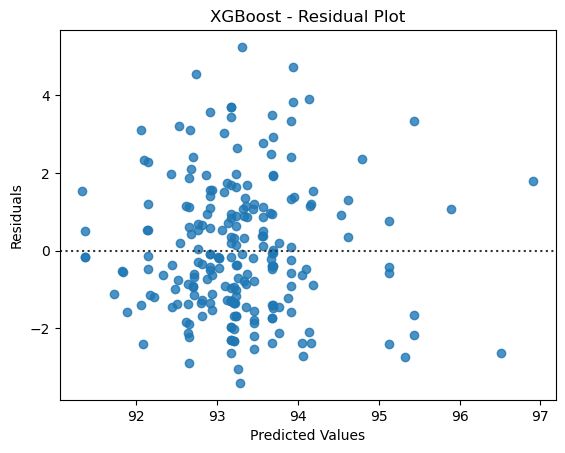

In [21]:
sns.residplot(data = error_df, 
              x = 'y_pred', 
              y = 'residual')
plt.title('XGBoost - Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

### Feature Importance

In [22]:
xgb_best_pipeline = xgb.best_estimator_
importances = np.abs(xgb_best_pipeline.named_steps['xgBoost'].feature_importances_)
indices = np.argsort(importances)[::-1]

In [23]:
n = 10
top_n_indices = indices[:n]
top_n_features = X.columns[top_n_indices]

for feature, importance in zip(top_n_features, importances[top_n_indices]):
    print(feature, "=", importance)

Apr_Total_Precipitation = 0.028329087
Jun_Min_High_Wind_Speed  = 0.026587388
Aug_Min_Low_Temperature = 0.023536831
Aug_Avg_Pressure = 0.020574357
Oct_Avg_High_Humidity = 0.020106379
Oct_Min_High_Temperature = 0.017664114
Feb_Max_Low_Humidity = 0.016557539
Apr_Min_Low_Wind_Speed  = 0.016349664
Aug_Min_High_Temperature = 0.016166145
Oct_Avg_High_ Dew_Point = 0.01600692


### Write Pipeline to File

In [24]:
with open(models_folder + 'xgb_best_cv.pkl', 'wb') as f:
    dill.dump(xgb_best_pipeline, f)